<a href="https://colab.research.google.com/github/Chinmay-47/NLP_Udemy/blob/master/Cipher_NLP_Udemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import random
import numpy as np
import string
import requests
import re
import os
import textwrap
import matplotlib.pyplot as plt

In [160]:
#substitution cipher

#one is the key and one will be the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

#random mapping
mapping = {}

random.shuffle(letters2)

#populating the mapping
for k, v in zip(letters1, letters2):
    mapping[k]=v

# print(mapping)

In [161]:
#Language Model

#Transition matrix - Markov Model

M = np.ones((26,26))

#Initial state probabilities

pi = np.zeros(26)

def update_transition(char1,char2):
    i = ord(char1) - 97
    j = ord(char2) - 97
    M[i,j] +=1

def update_pi(char):
    i = ord(char)-97
    pi[i]+=1

def get_word_prob(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])

    for char in word[1:]:
        j = ord(char) - 97
        logp += np.log(M[i,j])
        i = j
    
    return logp


def get_sequence_prob(words):

    if type(words) == str:
        words = words.split()
    
    logp = 0

    for word in words:
        logp += get_word_prob(word)
    return logp

In [162]:
#Data

url = 'https://lazyprogrammer.me/course_files/moby_dick.txt'

data = requests.get(url)

with open('moby_dick.txt','w') as f:
    f.write(data.content.decode())

regex = re.compile('[^a-zA-Z]')

for line in open('moby_dick.txt'):
    line = line.rstrip()

    if line:
        line = regex.sub('', line)

        tokens = line.lower().split()

        for token in tokens:

            char0 = token[0]
            update_pi(char0)

            for char1 in token[1:]:
                update_transition(char0,char1)
                char0 = char1
        
pi /=pi.sum()
M /=M.sum(axis=1, keepdims=True)

In [163]:
#Message to be encrypted

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [164]:
#encoding and decoding

def encode_message(message):
    message = message.lower()

    message = regex.sub('',message)

    coded_message = []
    for char in message:
        coded_char = char
        if char in mapping:
            coded_char = mapping[char]
        coded_message.append(coded_char)
    
    return ''.join(coded_message)

encoded_message = encode_message(original_message)

def decode_message(message, word_map):

    decoded_message = []
    for char in message:
        decoded_char = char
        if char in word_map:
            decoded_char = word_map[char]
        decoded_message.append(decoded_char)
    
    return ''.join(decoded_message)

In [165]:
# Evolutionary/Genetic Algorithm

dna_pool = []

for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [166]:
def evolve_offsprings(dna_pool, n_offsprings):

    offsprings = []

    for dna in dna_pool:
        for _ in range(n_offsprings):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))

            #swap

            temp = copy[j]
            copy[j] = copy[k]
            copy[k] = temp
            offsprings.append(copy)

    return offsprings + dna_pool

In [167]:
#Training

iterations = 1000
scores = np.zeros(iterations)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(iterations):

    if i > 0:
        dna_pool = evolve_offsprings(dna_pool, 3)

    dna2score = {}
    for dna in dna_pool:
        current_map = {}
        for k,v in zip(letters1, dna):
            current_map[k] = v

        decoded_message = decode_message(encoded_message,current_map)
        score = get_sequence_prob(decoded_message)
        dna2score[''.join(dna)] = score

        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score

    scores[i] = np.mean(list(dna2score.values()))


    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)

    dna_pool = [list(k) for k,v in sorted_dna[:5]]

    if i % 200 == 0:
        print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -1873.6514541035099 best so far: -1591.9696106608415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


iter: 200 score: -1024.4411732224041 best so far: -968.8711213467294
iter: 400 score: -1018.7935584282767 best so far: -968.8711213467294
iter: 600 score: -1013.6434613249792 best so far: -968.8711213467294
iter: 800 score: -1041.6609352331634 best so far: -968.8711213467294


In [168]:
#Using best maps and score

decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub('', original_message.lower())))

# which letters are wrong?
for true, v in mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -968.8711213467294
LL of true message: -972.044274749855
true: k, pred: q
true: q, pred: z
true: z, pred: k


In [169]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 ithenloungeddownthestreetandfoundasiexpectedthattherewasamewsinalanewh
ichrunsdownbyonewallofthegardenilenttheostlersahandinrubbingdowntheirh
orsesandreceivedinexchangetwopenceaglassofhalfandhalftwofillsofshagtob
accoandasmuchinformationasicoulddesireaboutmissadlertosaynothingofhalf
adokenotherpeopleintheneighbourhoodinwhomiwasnotintheleastinterestedbu
twhosebiographiesiwascompelledtolistento

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.



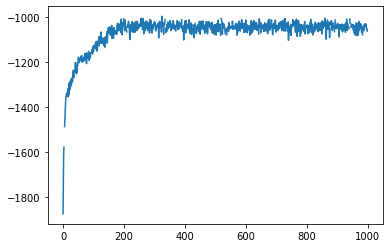

In [170]:
plt.plot(scores)
plt.show()